In [1]:
import pandas as pd
from nilearn import masking
from nilearn.glm.first_level import FirstLevelModel


def lsa_transformer(df):
    """Labels trials for an LSA model."""
    conditions = df["trial_type"].unique()
    df["old_trial_type"] = df["trial_type"]
    condition_counter = {c: 0 for c in conditions}
    for i_trial, trial in df.iterrows():
        trial_condition = trial["old_trial_type"]
        condition_counter[trial_condition] += 1
        trial_name = f"{trial_condition}_{condition_counter[trial_condition]:03d}"
        df.loc[i_trial, "trial_type"] = trial_name

    return df

# Constants
events_file = "/Users/taylor/Desktop/sub-108TUSW011005_ses-1_task-imagery_acq-Fs2_run-01_events.tsv"
fmri_file = "/Users/taylor/Desktop/sub-108TUSW011005_ses-1_task-imagery_acq-Fs2_run-01_bold.nii.gz"
mask = masking.compute_epi_mask(fmri_file)

# This example events file is taken from OpenNeuro:
# https://openneuro.org/datasets/ds003813/versions/1.0.0
events_df = pd.read_table(events_file)
# Remove fixation "trials"
events_df = events_df.loc[events_df["trial_type"] != "Fixation"]
lsa_events_df = lsa_transformer(events_df)

# Compute and collect beta maps
# NOTE: The variable "glm" comes from the Haxby example.
glm = FirstLevelModel(t_r=2.3)
glm.fit(fmri_file, lsa_events_df)

# It's a nilearn FirstLevelModel that has already been fitted to the fMRI data and events.
condition_beta_maps = {cond: [] for cond in lsa_events_df["old_trial_type"].unique()}
trialwise_conditions = lsa_events_df["trial_type"].unique()
for condition in trialwise_conditions:
    beta_map = glm.compute_contrast(condition, output_type="effect_size")
    # Drop the trial number from the condition name to get the original name.
    condition_name = "_".join(condition.split("_")[:-1])
    condition_beta_maps[condition_name].append(beta_map)

# NOTE: The variable "mask" should be provided by the user.
condition_beta_arrs = {}
for condition, maps in condition_beta_maps.items():
    beta_arr = masking.apply_mask(maps, mask)
    condition_beta_arrs[condition] = beta_arr

# NOTE: The end result should be a dictionary of condition: (trial-by-voxel)
# numpy array pairs.

/opt/miniconda3/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/opt/miniconda3/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:88: UserWarning: Unexpected column `old_trial_type` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "


In [5]:
print(lsa_events_df.head(10).to_markdown())

|    |   onset |   duration | trial_type   | old_trial_type   |
|---:|--------:|-----------:|:-------------|:-----------------|
|  1 |     8   |          7 | Right_001    | Right            |
|  3 |    23.6 |          7 | Left_001     | Left             |
|  5 |    38   |          7 | Both_001     | Both             |
|  7 |    50.9 |          7 | Both_002     | Both             |
|  9 |    66.9 |          7 | Both_003     | Both             |
| 11 |    82.9 |          7 | Left_002     | Left             |
| 13 |    97.2 |          7 | Right_002    | Right            |
| 15 |   111.1 |          7 | Right_003    | Right            |
| 17 |   125.6 |          7 | Left_003     | Left             |
| 19 |   140.1 |          7 | Both_004     | Both             |


/opt/miniconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


<AxesSubplot:label='conditions', ylabel='scan number'>

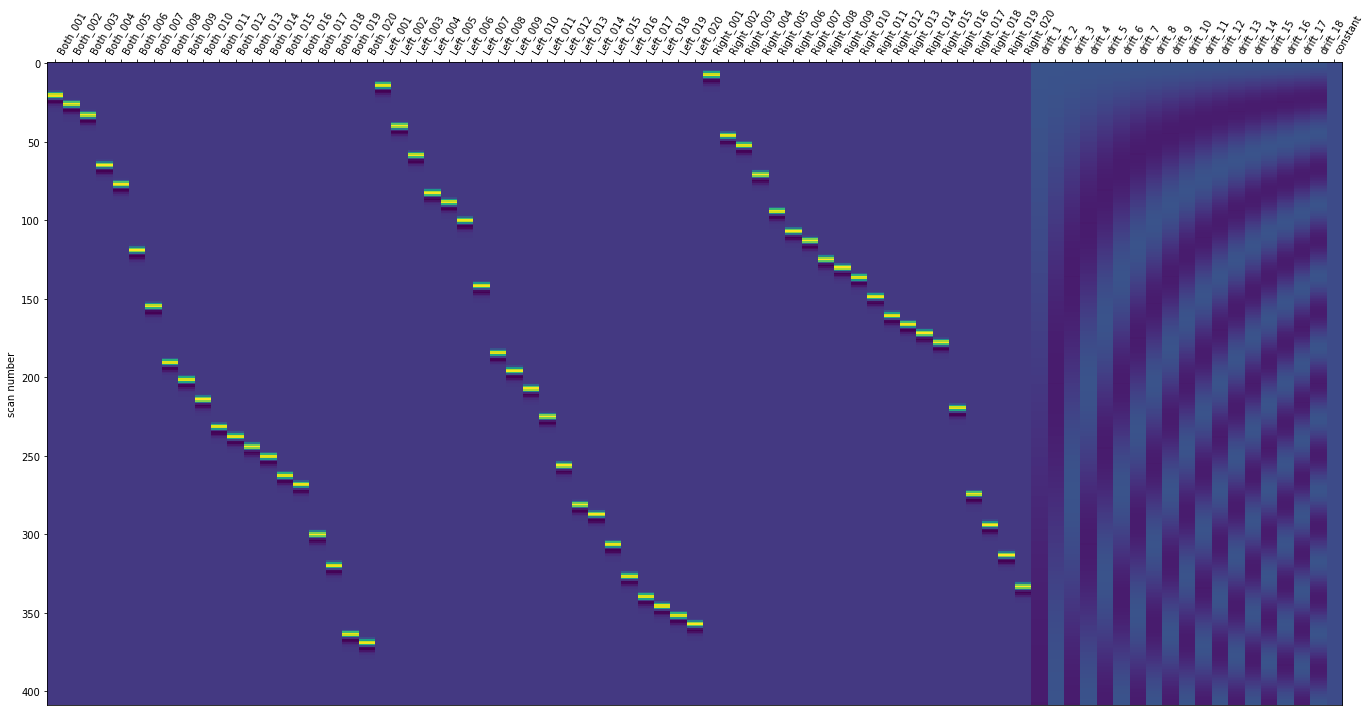

In [2]:
from nilearn import plotting

plotting.plot_design_matrix(glm.design_matrices_[0])